# Check GPU

In [1]:
!nvidia-smi

Thu Jun  9 11:17:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Library

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import shutil
import time
import matplotlib.pyplot as plt
from PIL import Image , ImageFilter
from sklearn.metrics import confusion_matrix, classification_report
import datetime
import csv
import seaborn as sns
import cv2
from sklearn.metrics import classification_report
sns.set_style('darkgrid')
from datetime import datetime
print ('modules loaded')

modules loaded


# ****Costum Callback****

In [3]:
class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training...")
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    def on_train_batch_begin(self, batch, logs=None):
        msg ="Training: Starting batch 1/"+str(batch)
        print("\r"+msg, end="") 
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg ="lost = "+str(float("{:.2f}".format(loss)))+"   accuracy= "+str(float("{:.2f}".format(acc)))
        print("\r"+msg, end="") 
    def on_epoch_end(self, epoch, logs=None):
        print(' ') 
        print(f"Finished epoch {epoch}, loss is {logs['loss']}, accuracy is {logs['accuracy']},val_accuracy is {logs.get('val_accuracy')},val_lost is {logs.get('val_loss')}")
        print(' ')  
    def on_train_end(self, logs=None):
        print("Finished training")

In [4]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# Data Praproses

In [5]:
def datalist (sdir,name):
    catpath=os.path.join(sdir, name)
    filepaths=[]
    labels=[]    
    classlist=os.listdir(catpath)
    for klass in classlist:
        classpath=os.path.join(catpath,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)               
    print('data_frame length: ', len(df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    return df



In [6]:
# buat praproses
def praproses(sdir):
    # Praproses - Gausian Noise
    file_name = './aug/'+sdir
    
    #buat fold
    if os.path.exists(file_name) == False:
        os.mkdir('./aug/'+sdir)
    dir = "../input/325-bird/"+sdir
    list_class = os.listdir(dir) 
    total_class = len(list_class)
    
    #looping data class
    for i in range(total_class):
        folder = "./aug/"+sdir+list_class[i]
        if os.path.exists(folder) == False:
            os.mkdir(folder)
        list_data = os.listdir(dir+list_class[i]) 
        total_data= len(list_data)
        
        #loop data file in class
        for j in range(total_data):
            
            name = list_data[j]
            lokasi_save = folder+'/'+ list_data[j]
            lokasi_file = dir+list_class[i]+'/'+list_data[j]
            
            #Grayscale 
            img = cv2.imread(lokasi_file)
            cv2.imwrite(lokasi_save, img)

In [7]:
#buat folder augmentasi
file_name = './aug'
if os.path.exists(file_name) == False:
    os.mkdir('./aug')
       
# buat file augmentasi
praproses("train/")
praproses("valid/")
praproses("test/")

In [8]:
sdir=r'./aug'
#create datalist train 
name = 'train'
train_df= datalist(sdir,name)
#create datalist valid
name = 'valid'
valid_df= datalist(sdir,name)
#create datalist test
name = 'test'
test_df= datalist(sdir,name)

data_frame length:  47332
data_frame length:  1625
data_frame length:  1625


In [9]:
column='labels'
working_dir = r'./aug'
img_size=(224,224)

In [10]:
def scalar(img):    
    return img

In [11]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
msg='                                                              for the train generator'
print(msg, '\r', end='') 
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='                                                              for the test generator'
print(msg, '\r', end='') 
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
msg='                                                               for the validation generator'
print(msg, '\r', end='')
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))
labels=test_gen.labels

test batch size:  65   test steps:  25
Found 47332 validated image filenames belonging to 325 classes.
Found 1625 validated image filenames belonging to 325 classes.
Found 1625 validated image filenames belonging to 325 classes.


In [12]:
#optimizer
opt = Adamax(learning_rate=0.0001)

In [13]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   # show 25 gambar
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

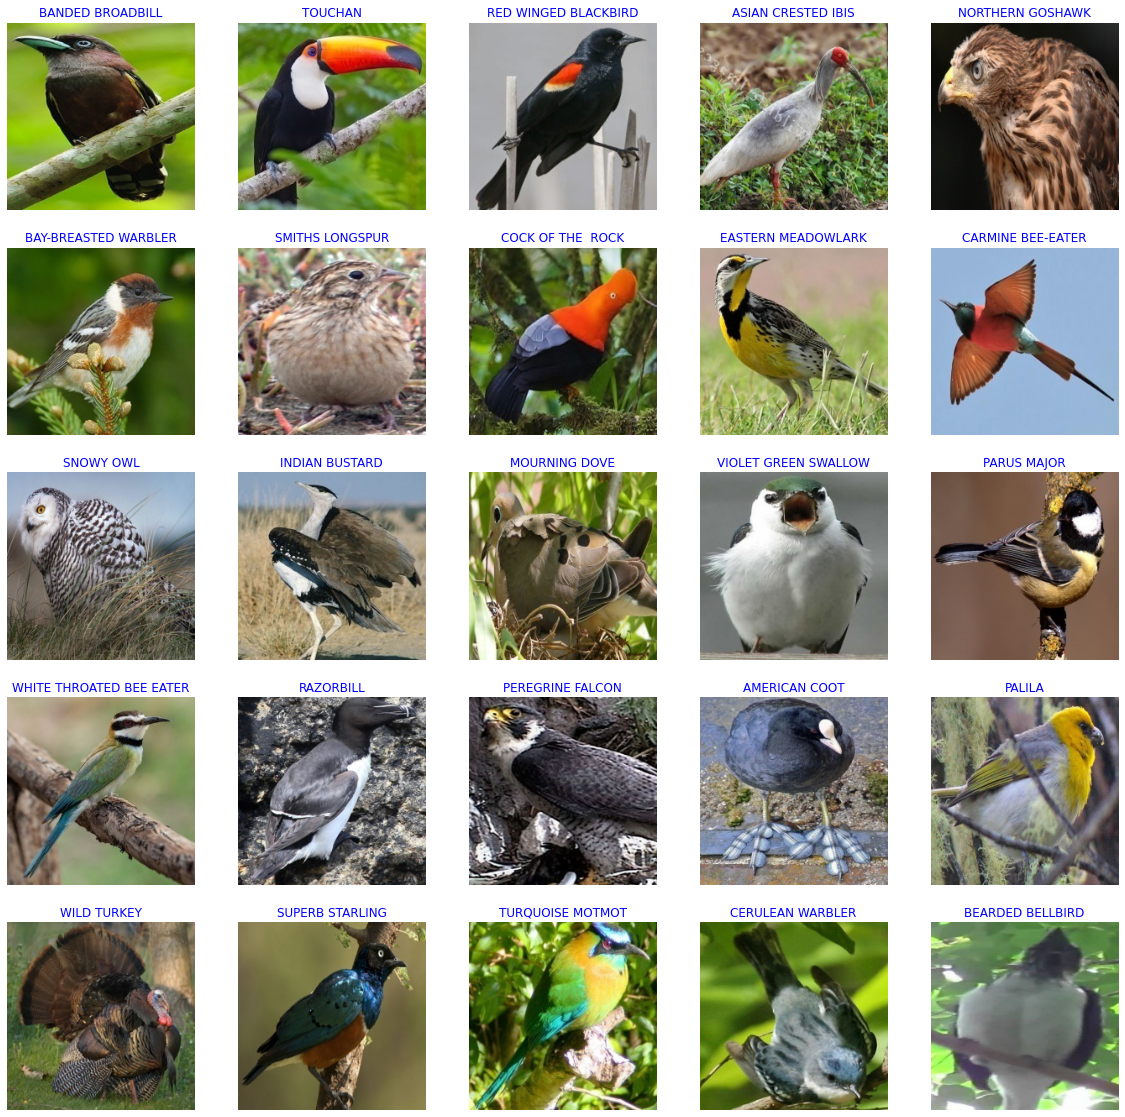

In [14]:
show_image_samples(train_gen)

# Membuat Model

In [15]:
model_name='InceptionResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization()(x)
x = Dense(512,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy']) 

2022-06-09 11:24:39.111082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 11:24:39.218038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 11:24:39.218809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 11:24:39.219940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 1s 0us/step


In [16]:
history=model.fit(x=train_gen,  epochs=20, verbose=0, callbacks=[TrainingCallback()],  validation_data=valid_gen)

Starting training...
Starting epoch 0
Training: Starting batch 1/0

2022-06-09 11:24:47.522070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-09 11:25:05.183933: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


lost = 3.13   accuracy= 40.9 
Finished epoch 0, loss is 3.132185935974121, accuracy is 0.4090256094932556,val_accuracy is 0.875076949596405,val_lost is 0.5910665988922119
 
Starting epoch 1
lost = 0.78   accuracy= 82.76 
Finished epoch 1, loss is 0.7804798483848572, accuracy is 0.8275585174560547,val_accuracy is 0.9366154074668884,val_lost is 0.36368510127067566
 
Starting epoch 2
lost = 0.37   accuracy= 91.11 
Finished epoch 2, loss is 0.37477532029151917, accuracy is 0.9110538363456726,val_accuracy is 0.9612307548522949,val_lost is 0.20059560239315033
 
Starting epoch 3
lost = 0.22   accuracy= 94.54 
Finished epoch 3, loss is 0.22354118525981903, accuracy is 0.94544917345047,val_accuracy is 0.964923083782196,val_lost is 0.1719544231891632
 
Starting epoch 4
lost = 0.14   accuracy= 96.54 
Finished epoch 4, loss is 0.14432021975517273, accuracy is 0.9654145240783691,val_accuracy is 0.9673846364021301,val_lost is 0.14422525465488434
 
Starting epoch 5
lost = 0.1   accuracy= 97.55 
Finis

# Plot History Learning

In [17]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

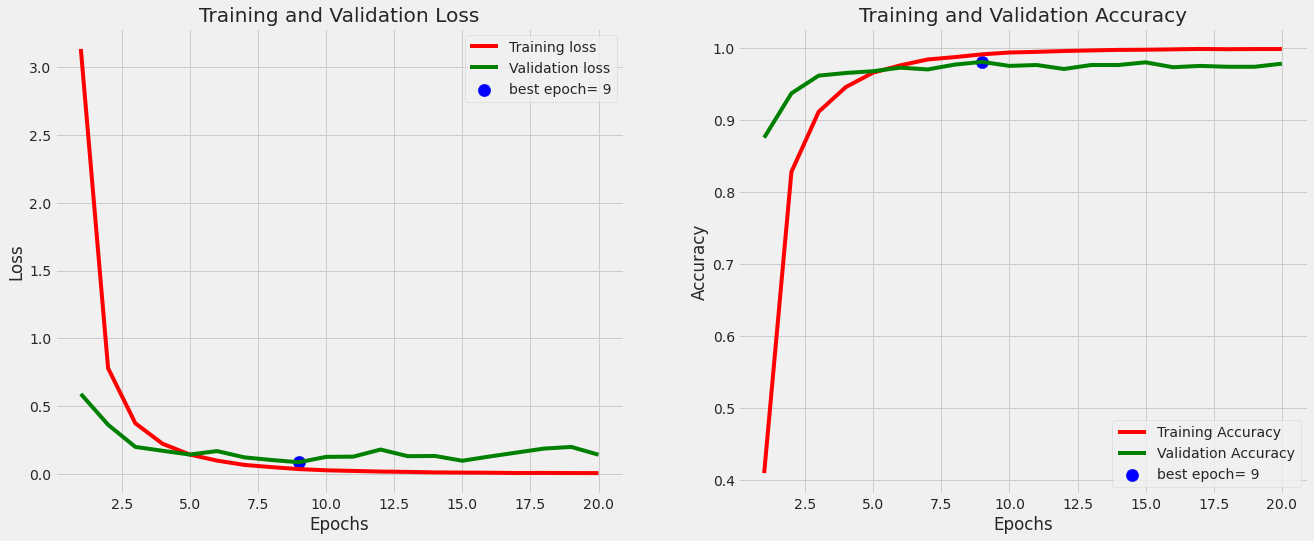

In [18]:
tr_plot(history,0)

In [35]:
model.save('./model_normal.h5')
model.save_weights('./weight_normal.h5')